In [1]:
#Импортируем библиотеки
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
from scipy import stats
%matplotlib inline

In [7]:
# Подключаемся к базе данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220620'
}

In [8]:
# Создаем запрос
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-05-17' and '2022-05-23'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

# Загружаем данные из clickhouse
df = ph.read_clickhouse(q, connection=connection)

In [9]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


In [10]:
# Измерим сколько пользователей в каждой группе
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [11]:
p_value = []
for i in range(10000):
    # Сформируем подвыборки для каждой из групп по 500 пользователей с параметром CTR
    a = df[df.exp_group == 2].ctr.sample(500, replace=True).values.tolist()
    b = df[df.exp_group == 3].ctr.sample(500, replace=True).values.tolist()
    
    # Проведем t-test по каждой из двух сформированных подвыборок и запишем все значения p-value в список
    p_value.append(stats.ttest_ind(a, b, equal_var=False).pvalue)

In [27]:
#Выведем несколько значений из получившегося списка, чтобы удостовериться в правильности полученного результата
p_value[0:3]

[0.23083219810017194, 0.7268497741663255, 0.042950394255500575]

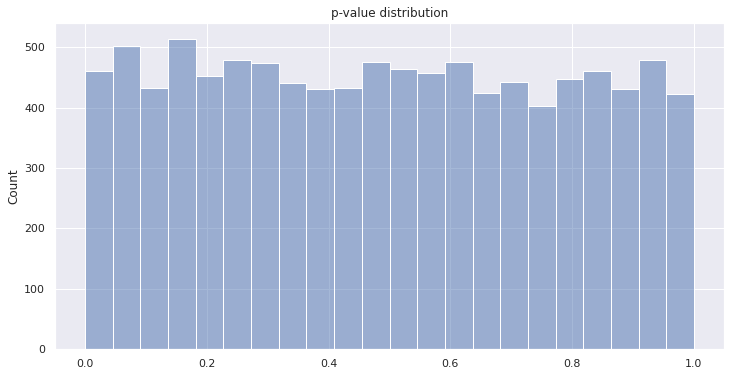

In [28]:
#установим размер гистограммы
sns.set(rc={'figure.figsize':(12,6)})
#отрисуем гистограмму распределения p-value
hist = sns.histplot(data = p_value, alpha = 0.5, kde=False)
hist.set_title('p-value distribution')
plt.show()

In [45]:
#сконвертируем список значений p_values в массив 
p_values = np.asarray(p_value)

In [47]:
#рассчитаем какой процент p values оказался меньше либо равен 0.05
pv_persentage = (p_values <= 0.05).sum()/len(p_value)*100
print(f'Доля p-values, которая оказалась меньше или равна 0.05 составила {pv_persentage}%')

Доля p-values, которая оказалась меньше или равна 0.05 составила 5.16%


Вывод: нам удалось отклонить нулевую гипотезу в 5.16% случаев при текущем количестве экспериментов (10000). Можно сделать вывод, что система сплитования в целом работает корректно, принимая во внимание факт, что получить статистически значимые различия между 2 и 3 группами должны получаться только в результате случайного ложного срабатывания, составляющего около 5%. Однако если эксперимент требует более высокой точности, то воможно следует либо увеличить количество экспериментов, либо применить другие методы статистического анализа.